# Recurrent Convolutional Neural Network

## Import Dependencies

In [1]:
%matplotlib inline
from imp import reload

import itertools
import numpy as np
import utils; reload(utils)

from utils import *
from __future__ import print_function
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG
from IPython.display import Image

/home/konstantin/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configure Parameters

In [3]:
# Embedding
embedding_size = 50
max_features = 5000
maxlen = 400

# Convolution
kernel_size = 5
pool_size = 4
filters = 64

# LSTM
lstm_output_size = 70

# Training
batch_size = 64
epochs = 4

## Data Preparation

In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [5]:
# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print('Train data size:', x_train.shape)
print('Test data size:', x_test.shape)

Train data size: (25000, 400)
Test data size: (25000, 400)


## Modelling

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 64)           16064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 71        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total para

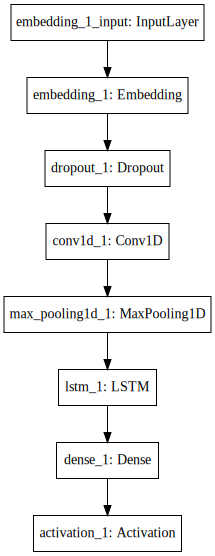

In [6]:
model = Sequential()

# Embedding layer
model.add(Embedding(max_features, 
                    embedding_size, 
                    input_length=maxlen))
model.add(Dropout(0.25))

# Convolutional layer
model.add(Conv1D(filters,
                kernel_size,
                padding='valid',
                activation='relu',
                strides=1))
model.add(MaxPooling1D(pool_size=pool_size))

# LSTM layer
model.add(LSTM(lstm_output_size))

# Squash
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

plot_model(model, to_file='model_rcnn.png', show_shapes=True)
Image(filename = 'model_rcnn.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Evaluation

In [7]:
# Train the model
model.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_test, y_test),
         verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 55s 2ms/step - loss: 0.3862 - acc: 0.8181 - val_loss: 0.2872 - val_acc: 0.8799
Epoch 2/4
25000/25000 [==============================] - 42s 2ms/step - loss: 0.2289 - acc: 0.9107 - val_loss: 0.2718 - val_acc: 0.8881
Epoch 3/4
25000/25000 [==============================] - 42s 2ms/step - loss: 0.1824 - acc: 0.9325 - val_loss: 0.2823 - val_acc: 0.8859
Epoch 4/4
25000/25000 [==============================] - 42s 2ms/step - loss: 0.1501 - acc: 0.9459 - val_loss: 0.3181 - val_acc: 0.8831


In [8]:
# Evaluate model
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
preds = model.predict_classes(x_test, batch_size=batch_size)

25000/25000 [==============================] - 8s 303us/step


In [9]:
# Save the model weights
model_path = 'models/'
model.save_weights(model_path + 'rcnn.model')

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[11324  1176]
 [ 1747 10753]]


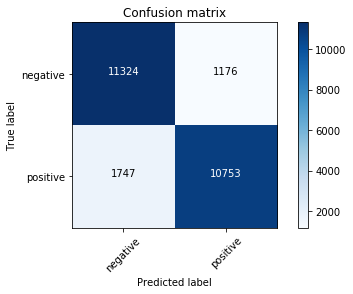

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, {'negative': 0, 'positive': 1})

In [12]:
# F1 score
f1_macro = f1_score(y_test, preds, average='macro') 
f1_micro = f1_score(y_test, preds, average='micro')

print('Test accuracy:', acc)
print('Test score (loss):', score)
print('')
print('F1 Score (Macro):', f1_macro)
print('F1 Score (Micro):', f1_micro)

Test accuracy: 0.8830800000190735
Test score (loss): 0.31811546688079834

F1 Score (Macro): 0.883018975023417
F1 Score (Micro): 0.88308
